In [1]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Model traning, image processing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder

In [2]:
def extract_and_split(zip_path, output_dir, split_ratio=0.8):
    """
    Extracts a zip file, merges class folders from training and testing, and performs a stratified train-test split.

    Parameters:
        zip_path (str): Path to the archive.zip file.
        output_dir (str): Path to the output directory where the train-test split will be stored.
        split_ratio (float): Proportion of data to use for training (default is 0.8).
    """
    # Temporary extraction path
    temp_dir = os.path.join(output_dir, "temp")

    # Ensure output and temp directories exist
    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

    # Extract zip file
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Paths to class folders inside the training and testing directories
    class_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
    dataset_folder = os.path.join(output_dir, "dataset")
    os.makedirs(dataset_folder, exist_ok=True)

    # Merge all class folders from training and testing
    print("Merging training and testing folders...")
    for class_name in class_folders:
        class_dir = os.path.join(dataset_folder, class_name)
        os.makedirs(class_dir, exist_ok=True)
        for base_folder in ['Training', 'Testing']:
            base_path = os.path.join(temp_dir, base_folder, class_name)
            if os.path.exists(base_path):
                for file_name in os.listdir(base_path):
                    src_file = os.path.join(base_path, file_name)
                    dest_file = os.path.join(class_dir, file_name)
                    if os.path.isfile(src_file):
                        shutil.copy(src_file, dest_file)

    # Create train-test split directories
    train_folder = os.path.join(output_dir, "train")
    test_folder = os.path.join(output_dir, "test")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Perform stratified splitting for each class
    print("Performing stratified train-test split...")
    for class_name in class_folders:
        class_dir = os.path.join(dataset_folder, class_name)
        all_files = os.listdir(class_dir)

        # Stratified train-test split
        train_files, test_files = train_test_split(
            all_files, train_size=split_ratio, random_state=42
        )

        # Copy files to train/test directories for the respective class
        class_train_dir = os.path.join(train_folder, class_name)
        class_test_dir = os.path.join(test_folder, class_name)
        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        for file_name in train_files:
            shutil.copy(os.path.join(class_dir, file_name), class_train_dir)
        for file_name in test_files:
            shutil.copy(os.path.join(class_dir, file_name), class_test_dir)

    print("Cleaning up temporary files...")
    shutil.rmtree(temp_dir)

    print("Train-test split completed.")


In [3]:
zip_path = "archive.zip"  # Path to your zip file
output_dir = "data"    # Path to the output directory

extract_and_split(zip_path, output_dir)
# if you get a zip file error, it hasn't finished uploading. Wait a few minutes

Extracting zip file...
Merging training and testing folders...
Performing stratified train-test split...
Cleaning up temporary files...
Train-test split completed.


In [4]:
def get_dataframe(file_dir):
    """
    Creates a pandas DataFrame from the training directory with file paths and labels.

    Parameters:
        train_dir (str): Path to the train directory.

    Returns:
        pd.DataFrame: A DataFrame with columns ['filepath', 'label'].
    """
    data = []
    for class_name in os.listdir(file_dir):
        class_path = os.path.join(file_dir, class_name)
        if os.path.isdir(class_path):  # Check if it's a folder (class directory)
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):  # Ensure it's a file
                    data.append({"filepath": file_path, "label": class_name})

    # Create a DataFrame
    df = pd.DataFrame(data)
    return df

In [5]:
train_dir = os.path.join("data", "train")  # Path to the train directory
train_df = get_dataframe(train_dir)

test_dir = os.path.join("data", "test")  # Path to the test directory
test_df = get_dataframe(test_dir)

In [6]:
len(train_df)

5617

In [7]:
len(test_df)

1406

In [8]:
# display label counts
train_df['label'].value_counts()

,count
label,
notumor,1600
pituitary,1405
meningioma,1316
glioma,1296


In [9]:
test_df['label'].value_counts()

,count
label,
notumor,400
pituitary,352
meningioma,329
glioma,325


In [10]:
def view_image_from_dataframe(df, image_column, index):
    """
    Displays an image from a dataframe based on the specified column and index.

    Args:
        df (pd.DataFrame): The dataframe containing image paths.
        image_column (str): The column name containing image file paths.
        index (int): The index of the image to view in the dataframe.

    Returns:
        None
    """
    try:
        # Get the image path from the dataframe
        image_path = df.loc[index, image_column]
        if not os.path.exists(image_path):
            print(f"Image path does not exist: {image_path}")
            return

        # Load and display the image
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis
        plt.title(f"Image at Index {index}")
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# Example Usage:
# Assuming `df` is a dataframe with a column 'image_path' containing file paths to images
# view_image_from_dataframe(df, 'image_path', 0)  # Displays the image at index 0


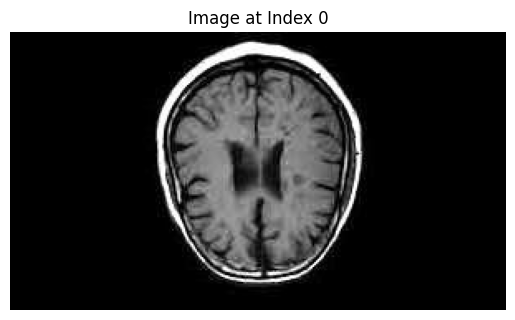

In [11]:
view_image_from_dataframe(train_df, 'filepath', 0)

In [12]:
def find_max_dimensions(image_paths):
    max_width = 0
    max_height = 0

    for image_path in image_paths:
        try:
            with Image.open(image_path) as img:
                width, height = img.size  # Get image dimensions
                max_width = max(max_width, width)
                max_height = max(max_height, height)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    return max_width, max_height

# Example Usage:
# Assuming `image_files` is a list of image file paths
# max_width, max_height = find_max_dimensions(image_files)
# print(f"Maximum Width: {max_width}, Maximum Height: {max_height}")


In [13]:
max(find_max_dimensions(train_df.iloc[:,0]))

1920

In [14]:
target_size = (1000, 1000)

In [15]:
def parse_function(file_name, label):
    """
    Resize and pad an image to match the target size while maintaining aspect ratio.
    """
    target_size = max(find_max_dimensions(train_df.iloc[:,0])) # update with target size
    target_size = (target_size, target_size)
    image = tf.io.read_file(file_name)
    if image is None:
        raise FileNotFoundError(f"File not found: {file_name}")
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, 1000, 1000)

    # Normalize pixel values to [0, 1]
    image = image / 255.0

    label = to_categorical(label, 4)

    return image, label

In [16]:
len(train_df)

5617

In [17]:
# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Divide the shuffled DataFrame into chunks of 200 rows each
chunk_size = 100
chunks = [train_df.iloc[i:i + chunk_size] for i in range(0, len(train_df), chunk_size)]

# Check the number of chunks
print(f"Total chunks created: {len(chunks)}")

# Example: Access the first chunk
chunk_1 = chunks[0]
print(chunk_1.head())



Total chunks created: 57
                               filepath       label
0  data/train/meningioma/Tr-me_1147.jpg  meningioma
1  data/train/meningioma/Tr-me_1303.jpg  meningioma
2     data/train/notumor/Tr-no_0680.jpg     notumor
3      data/train/glioma/Te-gl_0089.jpg      glioma
4   data/train/pituitary/Tr-pi_1376.jpg   pituitary


In [18]:
len(chunks[56])

17

In [19]:
def process_chunk(dataset):
    """
    Processes a chunk of the dataset to extract X_train and y_train.

    Parameters:
    - dataset (pd.DataFrame): A DataFrame chunk containing 'filepath' and 'label' columns.

    Returns:
    - X_train (np.ndarray): Array of processed images.
    - y_train (np.ndarray): Array of corresponding labels.
    """
    # Encode labels
    label_encoder = LabelEncoder()
    dataset['label'] = label_encoder.fit_transform(dataset['label'])

    # Parse data and store in arrays
    X_train, y_train = [], []
    for index, row in dataset.iterrows():
        image_path = row['filepath']
        label = row['label']

        # Call the user-defined parse_function to process the image and label
        img, lbl = parse_function(image_path, label)

        X_train.append(img)
        y_train.append(lbl)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train

In [20]:
print(target_size)

(1000, 1000)


In [21]:
num_classes = 4
img_rows, img_cols = target_size


model = Sequential([
    Input(shape=(img_rows, img_cols, 1)),  # Input for grayscale images
    # Convolutional Layer 1
    Conv2D(4, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Layer 2
    Conv2D(8, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Layer 3
    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Global Average Pooling (replaces Flatten)
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(32, activation='relu'),  # Reduce units to manage parameters
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # Output layer
])


In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 998, 998, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 998, 998, 4)         │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 499, 499, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 499, 499, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 497, 497, 8)         │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 497, 497, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 248, 248, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 248, 248, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 246, 246, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 246, 246, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 123, 123, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 123, 123, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,292 (8.95 KB)

 Trainable params: 2,236 (8.73 KB)

 Non-trainable params: 56 (224.00 B)

In [41]:
for i in range(10):
    X_train, y_train = process_chunk(chunks[i])
    history = model.fit(
    X_train,
    y_train,
    epochs=3,
    verbose = 1
)
model.save('brain_tumor_classification_model_img800_by_1000.h5')

<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.3298 - loss: 1.3790
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.3579 - loss: 1.3743
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.3475 - loss: 1.3725


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.3419 - loss: 1.3762
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.3732 - loss: 1.3725
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.3388 - loss: 1.3725


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.2423 - loss: 1.3895
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step - accuracy: 0.2015 - loss: 1.4079
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.2225 - loss: 1.3981


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.3605 - loss: 1.3709
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.3148 - loss: 1.3848
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.3390 - loss: 1.3721


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.3888 - loss: 1.3620
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.3378 - loss: 1.3709
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.3492 - loss: 1.3718


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.3143 - loss: 1.3654
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.3143 - loss: 1.3767
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 10s/step - accuracy: 0.3268 - loss: 1.3810


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.3179 - loss: 1.3788
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.2804 - loss: 1.3863
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.2983 - loss: 1.3753


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.2727 - loss: 1.3833
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.2788 - loss: 1.3901
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.2776 - loss: 1.3849


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step - accuracy: 0.3739 - loss: 1.3756
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.3801 - loss: 1.3796
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.4166 - loss: 1.3654


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - accuracy: 0.2773 - loss: 1.3887
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - accuracy: 0.2992 - loss: 1.3785
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.2731 - loss: 1.3880


In [42]:
#Checking what the history stores after training in multiple chunks
print("accuracy: ", history.history['accuracy'], "\n loss: ", history.history['loss'])

accuracy:  [0.30000001192092896, 0.30000001192092896, 0.30000001192092896] 
 loss:  [1.3810439109802246, 1.3797334432601929, 1.382227897644043]


In [43]:
X_train, y_train = process_chunk(chunks[30])

<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


In [44]:
# Train the model with multiple epoch to see the accuracy changes
epochs = 10

model_1 = model
# Train the model using the generator
history = model_1.fit(
    X_train,
    y_train,
    epochs=epochs,
    verbose = 1
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.2403 - loss: 1.4038
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.2632 - loss: 1.3919
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.2465 - loss: 1.3928
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.2549 - loss: 1.3927
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.2861 - loss: 1.3811
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.2622 - loss: 1.3861
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.2580 - loss: 1.3876
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.2611 - loss: 1.3919
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.2747 - loss: 1.3816
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.2497 - loss: 1.3839


In [45]:
len(test_df.iloc[:5])

5

In [28]:
#from tensorflow.keras.models import load_model

# Specify the path to your model file
#model_path = './brain_tumor_classification_model_img800_by_train1000.h5'

# Load the model
#model = load_model(model_path)

# Verify the model has been loaded
#model.summary()


In [46]:
# Shuffle the DataFrame
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Divide the shuffled DataFrame into chunks of 200 rows each
test_chunk_size = 100
test_chunks = [test_df.iloc[i:i + chunk_size] for i in range(0, len(test_df), test_chunk_size)]

# Check the number of chunks
print(f"Total chunks created: {len(test_chunks)}")

# Example: Access the first chunk
test_chunk_1 = test_chunks[0]
print(test_chunk_1.head())


Total chunks created: 15
                              filepath       label
0     data/test/notumor/Tr-no_0257.jpg     notumor
1     data/test/notumor/Tr-no_0752.jpg     notumor
2  data/test/meningioma/Tr-me_0068.jpg  meningioma
3  data/test/meningioma/Tr-me_1049.jpg  meningioma
4  data/test/meningioma/Tr-me_0950.jpg  meningioma


In [47]:
len(test_chunks[14])

6

In [49]:
# prepaing test_df for evaluating the model
X_test, y_test = process_chunk(test_chunks[0])

<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


In [50]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.3110 - loss: 1.3848
Test Loss: 1.3769503831863403
Test Accuracy: 0.3400000035762787


In [51]:
test_loss, test_accuracy = model_1.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3110 - loss: 1.3848
Test Loss: 1.3769503831863403
Test Accuracy: 0.3400000035762787


In [52]:
# Initialize variables for accumulating correct predictions and total samples
total_correct_predictions = 0
total_samples = 0

# Loop through all test_chunks
for chunk in test_chunks:
    # Process the chunk to get X_test and y_test
    X_test, y_test = process_chunk(chunk)

    # Evaluate the model on the current chunk
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

    # Calculate the number of correct predictions for this chunk
    correct_predictions = test_accuracy * len(y_test)

    # Update totals
    total_correct_predictions += correct_predictions
    total_samples += len(y_test)

# Calculate overall accuracy
overall_test_accuracy = total_correct_predictions / total_samples

# Print the combined accuracy
print(f"Combined Test Accuracy: {overall_test_accuracy:.4f}")


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3110 - loss: 1.3848


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3318 - loss: 1.3818


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3892 - loss: 1.3676


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2035 - loss: 1.3971


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3216 - loss: 1.3764


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1525 - loss: 1.4050


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.2736 - loss: 1.3818


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.2950 - loss: 1.3840


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3523 - loss: 1.3720


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3061 - loss: 1.3866


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2038 - loss: 1.4027


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2809 - loss: 1.3833


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.1698 - loss: 1.4015


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2674 - loss: 1.3852


<ipython-input-19-ded96249921e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 0.1667 - loss: 1.3847
Combined Test Accuracy: 0.2845


In [53]:
# Print the combined accuracy
print(f"Combined Test Accuracy: {overall_test_accuracy:.4f}")

Combined Test Accuracy: 0.2845
